In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import copy
import skimage.filters.rank
import skimage.morphology
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import pywt
from skimage.filters import rank
from skimage.morphology import disk
from glob import glob
from PIL import Image

In [2]:
from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import confusion_matrix

def accuracy_func(image1, image2):

    segmented_vessels = image1
    segmented_image = image2

    # Calculate SSIM and PSNR
    ssim_score = ssim(segmented_image, segmented_vessels)
    psnr_score = float('inf')
    mse = np.mean((image1 - image2) ** 2)
    if mse != 0:
        max_pixel = 255.0
        psnr_score = 20 * np.log10(max_pixel / np.sqrt(mse))
    # psnr_score = psnr(segmented_image, segmented_vessels)

    # Convert the images to binary (0 and 255) for calculating accuracy, sensitivity, and specificity
    generated_binary = (segmented_vessels > 0).astype(np.uint8)
    target_binary = (segmented_image > 0).astype(np.uint8)

    # Calculate accuracy, sensitivity, and specificity
    tn, fp, fn, tp = confusion_matrix(target_binary.ravel(), generated_binary.ravel()).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2/((1/specificity)+(1/sensitivity))
    # Print the performance metrics
    print(f'SSIM: {ssim_score:.4f}')
    print(f'PSNR: {psnr_score:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'f1: {f1:.4f}')

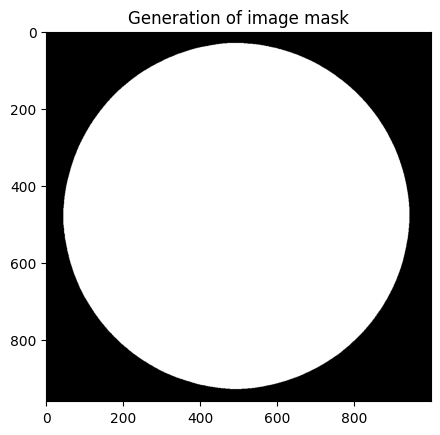

In [3]:

# Assuming inputImage is already loaded using cv2.imread()
inputImage = cv2.imread('C:\\Users\\utsav\\Desktop\\Input\\Image_01L.jpg', cv2.IMREAD_GRAYSCALE)

# Thresholding to convert the image to binary
_, mask = cv2.threshold(inputImage, 20, 255, cv2.THRESH_BINARY)

# Creating a structuring element of diamond shape of size 20
se = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))

# Eroding the mask using the structuring element
erodedmask = cv2.erode(mask, se, iterations=1)

# Converting the image to uint8
erodedmask = np.uint8(erodedmask)

# Displaying the eroded mask
plt.figure()
plt.imshow(erodedmask, cmap='gray')
plt.title("Generation of image mask")
plt.show()

(960, 999, 3)


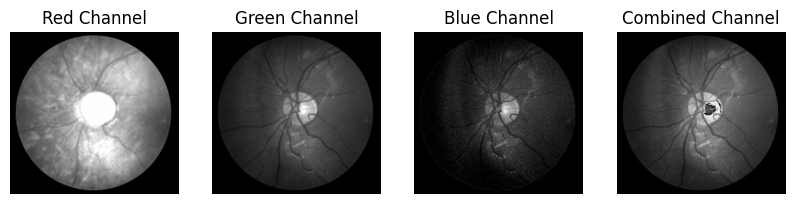

In [4]:
img = Image.open('C:\\Users\\utsav\\Desktop\\Input\\Image_01L.jpg')

# Convert the image to a numpy array
img_array = np.array(img)

print(img_array.shape)

# Separate the color channels
red_channel = img_array[:, :, 0]
green_channel = img_array[:, :, 1]
blue_channel = img_array[:, :, 2]
combined_channel = green_channel + blue_channel

# Plotting the images
plt.figure(figsize=(10, 5))

# Plot the red channel
plt.subplot(1, 4, 1)
plt.imshow(red_channel, cmap='gray')
plt.title('Red Channel')
plt.axis('off')

# Plot the green channel
plt.subplot(1, 4, 2)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

# Plot the blue channel
plt.subplot(1, 4, 3)
plt.imshow(blue_channel, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(combined_channel, cmap='gray')
plt.title('Combined Channel')
plt.axis('off')

# Show the plot
plt.show()


The different channel confirms our hypothesis that green channel exhibits better contrast between the vessels and the background

(array([2.93806e+05, 2.20500e+03, 4.67000e+02, 5.09000e+02, 3.10000e+02,
        5.91000e+02, 8.20000e+02, 1.84200e+03, 2.24900e+03, 8.57600e+03,
        2.30720e+04, 1.90640e+04, 3.02390e+04, 2.26250e+04, 3.49650e+04,
        2.81290e+04, 3.86670e+04, 2.43520e+04, 3.78710e+04, 2.46940e+04,
        3.85240e+04, 3.34080e+04, 2.09040e+04, 2.74580e+04, 1.64050e+04,
        2.37410e+04, 1.49610e+04, 2.02720e+04, 1.19540e+04, 1.66090e+04,
        1.57130e+04, 1.01950e+04, 1.52850e+04, 1.01710e+04, 1.44690e+04,
        8.31800e+03, 1.04120e+04, 5.64700e+03, 6.77500e+03, 3.73200e+03,
        4.28800e+03, 3.24600e+03, 1.78200e+03, 2.18700e+03, 1.17200e+03,
        1.60700e+03, 8.78000e+02, 1.17600e+03, 7.39000e+02, 1.17900e+03,
        1.32200e+03, 8.61000e+02, 1.33800e+03, 7.78000e+02, 1.25400e+03,
        8.47000e+02, 1.13400e+03, 5.48000e+02, 7.42000e+02, 4.63000e+02,
        5.95000e+02, 4.78000e+02, 2.83000e+02, 4.45000e+02, 2.43000e+02,
        3.88000e+02, 2.99000e+02, 4.27000e+02, 3.35

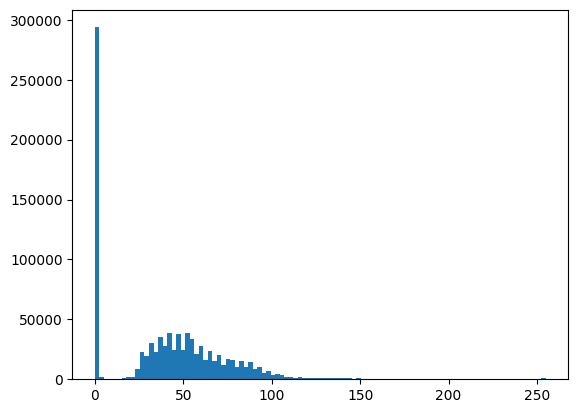

In [5]:
plt.hist(green_channel.flat, bins=100, range=(0, 255))

(array([291689.,   8861.,   4117.,   6708.,   5936.,   7734.,      0.,
          9402.,   9749.,      0.,   9315.,   9254.,  10030.,      0.,
         10955.,      0.,  11385.,      0.,  11240.,  11196.,      0.,
         11208.,      0.,  12561.,      0.,  13876.,      0.,  14253.,
             0.,  13970.,      0.,  12734.,  11963.,      0.,  12076.,
             0.,  12276.,      0.,  12769.,      0.,  12704.,      0.,
         12398.,  12113.,      0.,  12581.,      0.,  12899.,      0.,
         13105.,      0.,  12520.,      0.,  11840.,  11089.,      0.,
         10479.,      0.,  10567.,  10337.,      0.,   9770.,   9184.,
          8504.,      0.,   8279.,   8126.,   8153.,   7855.,   7733.,
          7488.,      0.,  14538.,      0.,  13207.,      0.,  11954.,
          5640.,   5492.,   5477.,  10573.,   5140.,   5151.,  10265.,
          5064.,   5000.,   5135.,  10031.,   4845.,   8929.,   7642.,
          6788.,   8079.,   6198.,   7308.,   5416.,   8281.,   5121.,
      

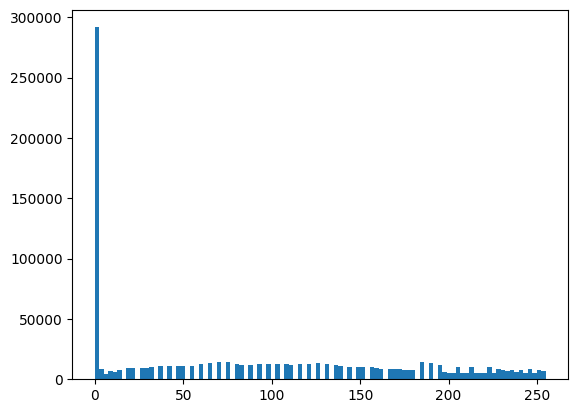

In [6]:
equ = cv2.equalizeHist(green_channel) #Explain what it does
plt.hist(equ.flat, bins=100, range=(0, 255))

(array([1.1000e+01, 1.5200e+02, 3.1350e+03, 2.8410e+05, 3.8690e+03,
        6.1310e+03, 2.4440e+03, 2.6940e+03, 1.8940e+03, 3.1750e+03,
        3.7240e+03, 2.8520e+03, 4.4250e+03, 3.0660e+03, 4.9690e+03,
        3.5910e+03, 5.6920e+03, 4.0550e+03, 6.4500e+03, 4.9510e+03,
        7.8040e+03, 8.7770e+03, 6.4640e+03, 1.0400e+04, 7.2770e+03,
        1.2162e+04, 8.6180e+03, 1.3211e+04, 9.0700e+03, 1.5016e+04,
        1.4869e+04, 1.0407e+04, 1.5808e+04, 1.0974e+04, 1.6351e+04,
        1.1028e+04, 1.7072e+04, 1.1232e+04, 1.7031e+04, 1.1636e+04,
        1.7421e+04, 1.7622e+04, 1.1779e+04, 1.7368e+04, 1.1359e+04,
        1.7263e+04, 1.0921e+04, 1.6334e+04, 1.0562e+04, 1.5572e+04,
        1.5031e+04, 9.4280e+03, 1.3915e+04, 9.0980e+03, 1.2841e+04,
        8.2450e+03, 1.1860e+04, 7.4970e+03, 1.0674e+04, 6.9820e+03,
        9.5520e+03, 8.9790e+03, 5.5790e+03, 7.9770e+03, 4.8610e+03,
        6.9620e+03, 4.5140e+03, 5.9460e+03, 3.8160e+03, 5.2270e+03,
        4.9050e+03, 3.0250e+03, 4.1030e+03, 2.48

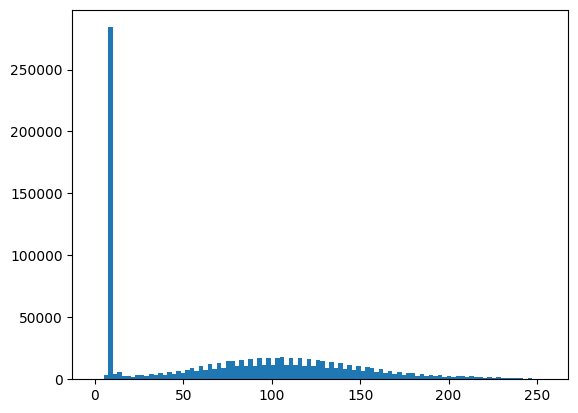

In [7]:
clahe = cv2.createCLAHE(clipLimit = 8, tileGridSize=(8,8))
cl_img = clahe.apply(green_channel)
plt.hist(cl_img.flat, bins=100, range=(0, 255))

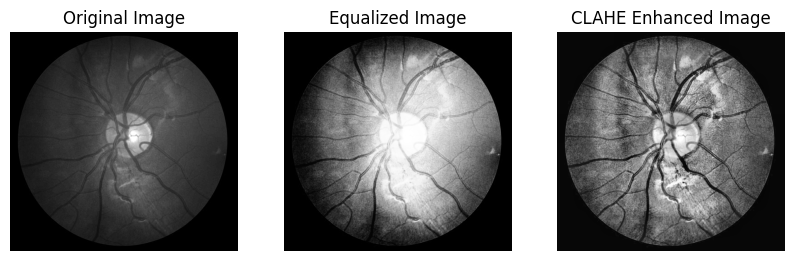

In [8]:
plt.figure(figsize=(10, 5))

# Plot the red channel
plt.subplot(1, 3, 1)
plt.imshow(green_channel, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the green channel
plt.subplot(1, 3, 2)
plt.imshow(equ, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cl_img, cmap='gray')
plt.title('CLAHE Enhanced Image')
plt.axis('off')

plt.show()

The histogram is highly tilted towards left, and therefore there is a need to equalize it. It improves but still the data is noisy so we try to do CLAHE (local contrasting)

After applying CLAHE, we can see the pixel plot is evenly distributed whilst not capturing noise as was the case for equalizing image. And therefore it improves contrast much effieciently.

Here best result were using adaptive thresholding cause:
Adaptive thresholding is useful when the lighting conditions are uneven or the image has varying background intensities. It calculates the threshold for each pixel based on the local neighbourhood of the pixel, which can improve the accuracy and robustness of image processing algorithms.

Text(0.5, 1.0, 'Replaced Black Ring')

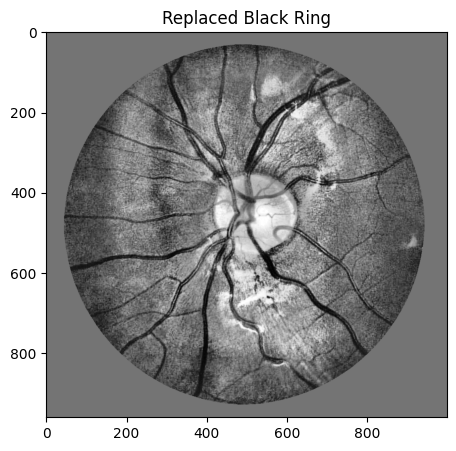

In [9]:
def replace_black_ring(im_enh, im_mask):
    row, col = im_mask.shape
    area_sum = np.zeros((50, 50))

    posit = np.ceil((np.random.rand(3, 2) + 1) * 1 / 3 * min(row, col)).astype(int)

    for i in range(3):
        x = posit[i, 0]
        y = posit[i, 1]
        area_rand = im_enh[x - 25:x + 25, y - 25:y + 25]  # Select the background
        area_sum = area_sum + area_rand

    area_sum = area_sum * 1 / 3

    mean_val = np.mean(area_sum)  # Calculate the mean of the array
    mean_mask = np.logical_not(im_mask) * mean_val  # Generate a new background
    im_new = mean_mask + im_enh * im_mask  # Overlay background

    return im_new, mean_val

im_new , lose = replace_black_ring(cl_img,erodedmask)
im_new = 255-im_new

fig = plt.figure(figsize=(10, 5))
plt.imshow(im_new,cmap='gray')
plt.title('Replaced Black Ring')


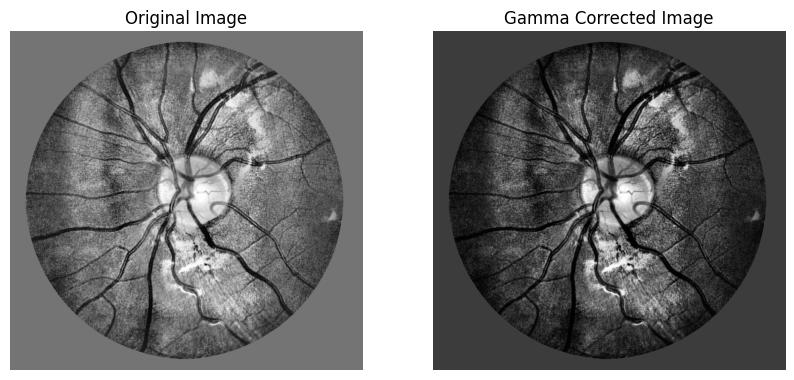

In [10]:
# Define the gamma value (you can experiment with different values)
gamma = 1.8

# Apply gamma correction
gc_image = np.power(im_new/float(np.max(green_channel)), gamma)
gc_image = np.uint8(gc_image * 255)

plt.figure(figsize=(10, 5))

# Plot the red channel
plt.subplot(1, 2, 1)
plt.imshow(im_new, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the green channel
plt.subplot(1, 2, 2)
plt.imshow(gc_image, cmap='gray')
plt.title('Gamma Corrected Image')
plt.axis('off')

plt.show()

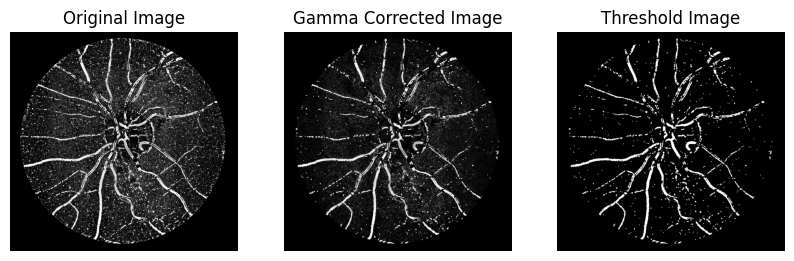

SSIM: 0.8387
PSNR: 55.1641
Accuracy: 0.9510
Sensitivity: 0.6932
Specificity: 0.9657
f1: 0.8071


In [11]:
#morphological operations, Here we do opening then closing
clahe_img  = gc_image

cell_disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
Topen = cv2.morphologyEx(clahe_img,cv2.MORPH_OPEN,cell_disc)
Tclose = cv2.morphologyEx(Topen, cv2.MORPH_CLOSE, cell_disc)

tophat_img = (clahe_img - Tclose)#.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
bottomhat_img = cv2.erode(tophat_img, kernel)
bottomhat_img = cv2.dilate(bottomhat_img, kernel)

plt.figure(figsize=(10, 5))

# Plot the red channel
plt.subplot(1, 3, 1)
plt.imshow(tophat_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the green channel
plt.subplot(1, 3, 2)
plt.imshow(bottomhat_img, cmap='gray')
plt.title('Gamma Corrected Image')
plt.axis('off')

ret, thresh = cv2.threshold(bottomhat_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(1, 3, 3)
plt.imshow(thresh, cmap='gray')
plt.title('Threshold Image')
plt.axis('off')

plt.show()


segmented_vessels = thresh
segmented_image = np.array(Image.open('C:\\Users\\utsav\\Desktop\\Output\\Image_01L_1stHO.png'))
segmented_image = segmented_image.astype(np.uint8)

accuracy_func(segmented_image,segmented_vessels)


In [12]:
#thresholding function
def threshold(img,k):
    ret = copy.deepcopy(img)
    ret[ret<k] = 0
    ret[ret>=k] = 255
    return ret

C:\Users\utsav\AppData\Local\Temp\ipykernel_6196\341585393.py:2: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  HessThin = hessian_matrix(thresh, sigma=1.2, order='rc')


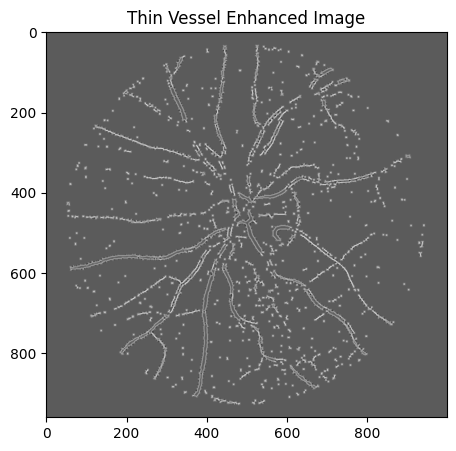

In [13]:
#hessian matrix and eigenvalues approach to get thin vessel enhanced image
HessThin = hessian_matrix(thresh, sigma=1.2, order='rc')
EignThin = hessian_matrix_eigvals(HessThin) [1]
fig = plt.figure(figsize=(10, 5))
plt.title("Thin Vessel Enhanced Image")
plt.imshow(1-EignThin, cmap=plt.cm.gray)

C:\Users\utsav\AppData\Local\Temp\ipykernel_6196\2147272853.py:2: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  HessWide = hessian_matrix(thresh, sigma=4, order='rc')


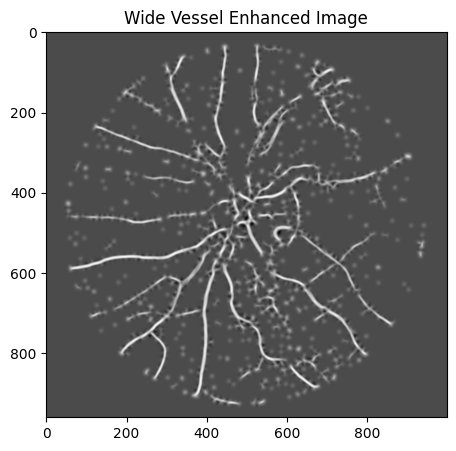

In [14]:
#hessian matrix and eigenvalues approach to get wide vessel enhanced image
HessWide = hessian_matrix(thresh, sigma=4, order='rc')
EignWide = hessian_matrix_eigvals(HessWide) [1]
fig = plt.figure(figsize=(10, 5))
plt.title("Wide Vessel Enhanced Image")
plt.imshow(1-EignWide, cmap='gray')

In [15]:
#global otsu thresholding function
def GlobalOtsu(img):
    foreground = img[img>=0]
    background = img[img<0]
    
    final_var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
    if(np.isnan(final_var)):
        final_var = -1
        
    final_thresh = 0
    for i in np.linspace(np.min(img), np.max(img), num=255):
        foreground = img[img>=i]
        background = img[img<i]
        var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
        
        if(np.isnan(var)):
            var = -1
            
        if(var!=-1 and (var<final_var or final_var ==-1)):
            final_var = var
            final_thresh = i
    return threshold(img,final_thresh)

In [16]:
#Area based thresholding/cleaning. Done as postprocessing step
def AreaThreshold(img, area = 5):
    nlabels,labels,stats,centroid = cv2.connectedComponentsWithStats(np.uint8(img), 4, cv2.CV_32S)

    output = np.copy(img)
    
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if stats[labels[i][j], cv2.CC_STAT_AREA] < area:
                output[i][j] = 0
                
    return output

In [17]:
#Local otsu thresholding


def LocalOtsu1(img,radius = 5):
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)
    
    output[output < local_otsu] = 0
    output[output >= local_otsu] = 255
    
    return output

In [18]:
#local Otsu thresholding function as per paper with offset included
def LocalOtsu2(img,radius = 15):
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)
    rng = local_otsu.max() - local_otsu.min()
    mid = rng/2 + local_otsu.min()

    local_otsu[local_otsu<mid] = mid

    output[output < local_otsu] = 0


    return output

In [19]:
def image_fusion(img1,img2):
    w1 = pywt.wavedec2(img1, 'db1')
    w2 = pywt.wavedec2(img2, 'db1')
    elem = (w1[0]+w2[0])/2
    fw = [elem]
    
    for i in range(len(w1)-1):
        x,y,z = (w1[i+1][0] + w2[i+1][0])/2, (w1[i+1][1] + w2[i+1][1])/2, (w1[i+1][2] + w2[i+1][2])/2
        fw.append((x,y,z))

    output = pywt.waverec2(fw, 'db1')
    
#     Normalisation, May or May not be required
    amin = np.min(output)
    amax = np.max(output)
    output = 255* ((output - amin)/(amax-amin))
    
    output = cv2.resize(output,img1.T.shape)
    return output

In [20]:
#Global otsu thresholding
val1 = GlobalOtsu(1-EignWide)

c:\Users\utsav\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\utsav\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\utsav\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'GlobalThresholdedThickVessel')

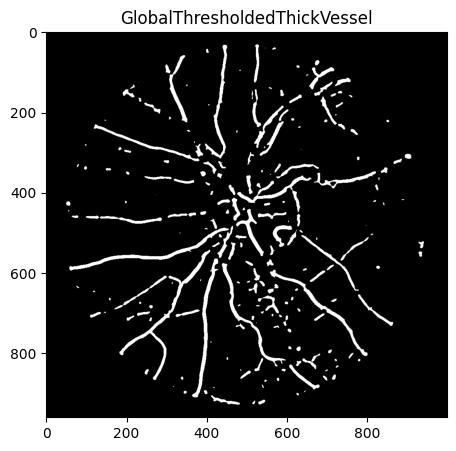

In [21]:
#Global otsu thresholded image
fig = plt.figure(figsize=(10, 5))
plt.imshow(val1,cmap='gray')
plt.title("GlobalThresholdedThickVessel")

In [22]:
#normalising the images for further processing
thinN = cv2.normalize(1-EignThin,  None, 0, 255, cv2.NORM_MINMAX)
val1 = cv2.normalize(val1,  None, 0, 70, cv2.NORM_MINMAX)

In [23]:
segmented_vessels = val1.astype(np.uint8)
segmented_image = np.array(Image.open('C:\\Users\\utsav\\Desktop\\Output\\Image_01L_1stHO.png'))
segmented_image = segmented_image.astype(np.uint8)
accuracy_func(segmented_image,segmented_vessels)

SSIM: 0.8625
PSNR: 39.7572
Accuracy: 0.9526
Sensitivity: 0.6901
Specificity: 0.9689
f1: 0.8060


Text(0.5, 1.0, 'Local Otsu Thresholding')

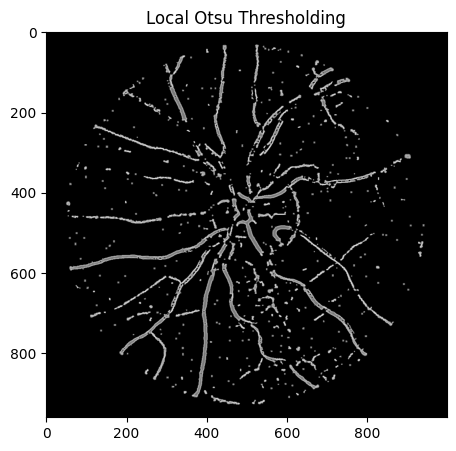

In [24]:
#local otsu thresholding on the fused image
test1 = image_fusion(val1,thinN)
lOtsu = LocalOtsu2(test1.astype('uint8'))
fig = plt.figure(figsize=(10, 5))
plt.imshow(lOtsu,cmap='gray')
plt.title("Local Otsu Thresholding")

Text(0.5, 1.0, 'Pixel/Area based Thresholding')

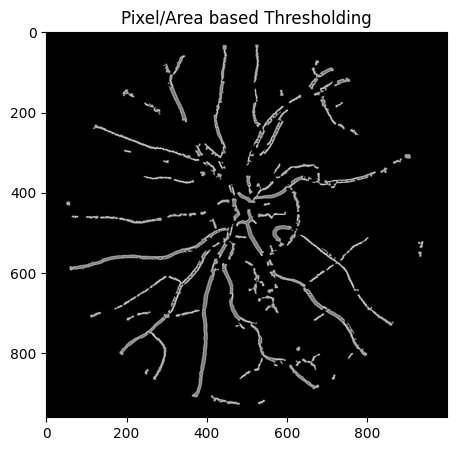

In [25]:
#area thresholding to remove non vessel regions
final = AreaThreshold(lOtsu,75)
fig = plt.figure(figsize=(10,5))
plt.imshow(final,cmap='gray')
plt.title("Pixel/Area based Thresholding")

Text(0.5, 1.0, 'Final Output')

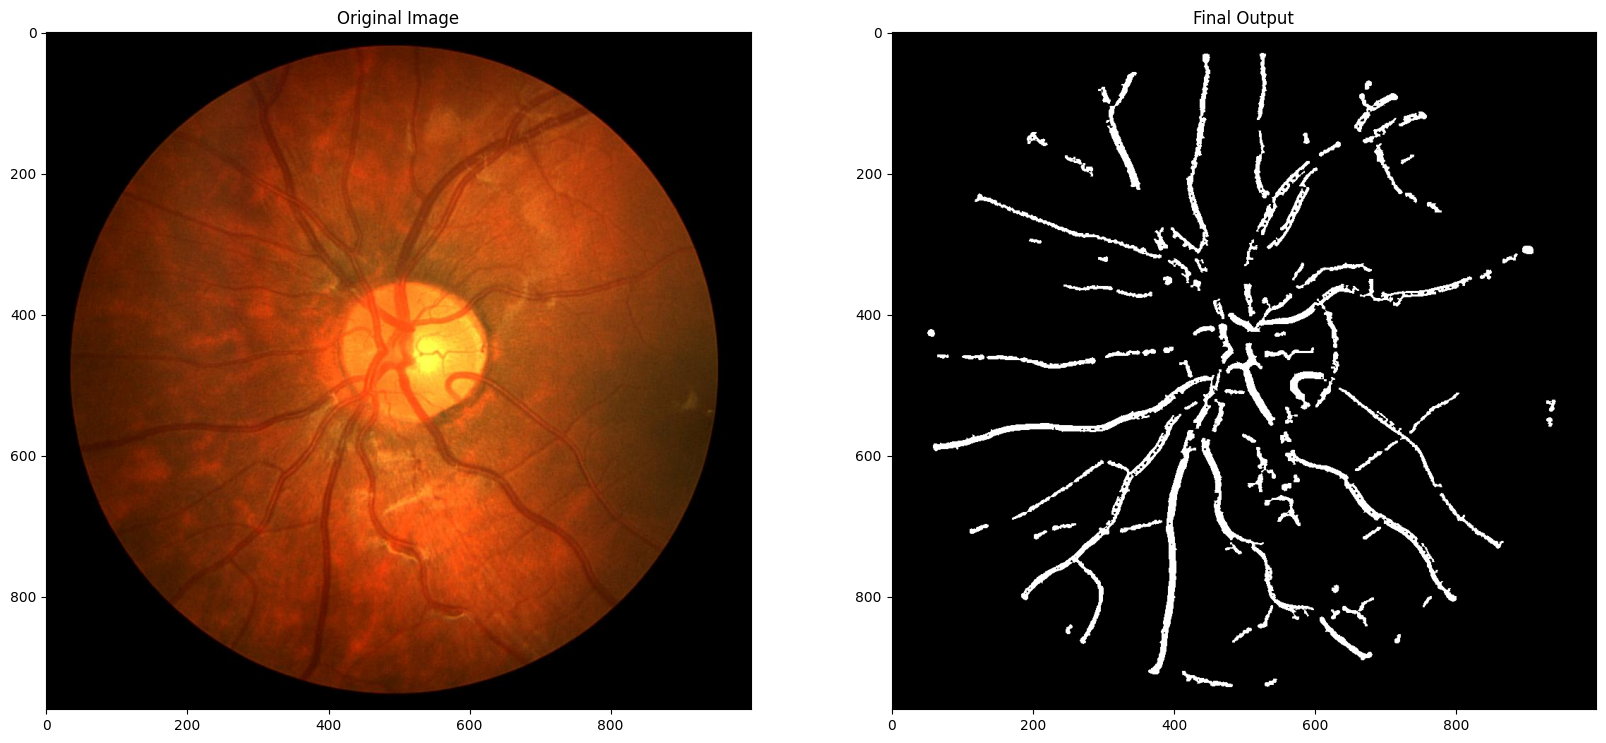

In [26]:
#binarizing final output and visualising it

final[final!=0] = 255

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
fig.add_subplot(1, 2, 2)
plt.imshow(final,cmap='gray')
plt.title("Final Output")

In [27]:
segmented_vessels = final
segmented_image = np.array(Image.open('C:\\Users\\utsav\\Desktop\\Output\\Image_01L_1stHO.png'))
segmented_image = segmented_image.astype(np.uint8)
accuracy_func(segmented_image,segmented_vessels)

SSIM: 0.8716
PSNR: 55.0540
Accuracy: 0.9549
Sensitivity: 0.7269
Specificity: 0.9680
f1: 0.8303


Shape of matched filter result: (960, 999)


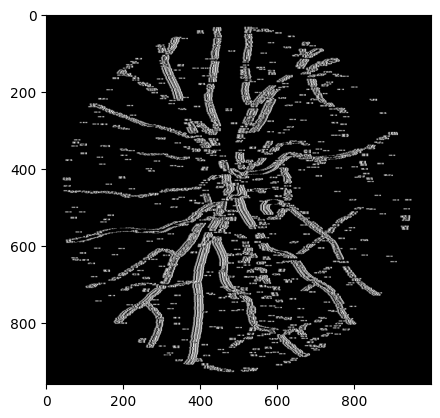

In [28]:
import numpy as np
import cv2
from scipy.ndimage import convolve


def apply_matched_filter_with_derivative(claheimg):
    sigma = 1.0
    size = int(6 * sigma)
    x = np.arange(-size // 2 + 1, size // 2 + 1)
    kernel = -x / (sigma**2) * np.exp(-x**2 / (2 * sigma**2))
    derivative_result = convolve(claheimg, kernel[np.newaxis])
    matched_filter_kernel = -kernel
    matched_filter_result = convolve(derivative_result, matched_filter_kernel[np.newaxis])
    matched_filter_result = (matched_filter_result - np.min(matched_filter_result)) / (np.max(matched_filter_result) - np.min(matched_filter_result)) * 255
    print("Shape of matched filter result:", matched_filter_result.shape)
    return matched_filter_result.astype(np.uint8)


def apply_first_order_gaussian_derivative(green_channel):
  sigma = 1.0
  size = int(6 * sigma)
  x = np.arange(-size // 2 + 1, size // 2 + 1)
  kernel = -x / (sigma**2) * np.exp(-x**2 / (2 * sigma**2))
  filtered_image = convolve(green_channel, kernel[np.newaxis])
  filtered_image = (filtered_image - np.min(filtered_image)) / (np.max(filtered_image) - np.min(filtered_image)) * 255
  return filtered_image.astype(np.uint8)

img = thresh
result = apply_matched_filter_with_derivative(img)
result = apply_first_order_gaussian_derivative(result)
plt.imshow(result, cmap='gray')